In [1]:
import platform
import pandas as pd
import numpy as np
from glob import glob
from tensorflow import keras

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
import utils
import models


Tensorflow version : 2.10.1

Tensorflow devices available : 
 [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14024334381040161164
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 22672310272
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17632151391174911882
physical_device_desc: "device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:61:00.0, compute capability: 8.6"
xla_global_id: 416903419
]

Tensorflow physical devices available : 
 [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
# Directory where the preprocessed volumetric data is located
kneemri_preprocessed_data_dir = 'Preprocessed_Data/KneeMRI'
# path to metadata csv file
kneemri_metadata_csv_path = 'Data/KneeMRI/metadata.csv'
kneemri_aug_metadata_csv_path = 'Data/KneeMRI/metadata-aug.csv'

In [6]:
# For running code on Windows
if platform.system() == "Windows":
    kneemri_preprocessed_data_dir = kneemri_preprocessed_data_dir.replace('/', '\\')
    kneemri_metadata_csv_path = kneemri_metadata_csv_path.replace('/', '\\')
    kneemri_aug_metadata_csv_path = kneemri_aug_metadata_csv_path.replace('/', '\\')

In [7]:
kneemri_classes = { 0:'healthy', 1:'partially ruptured', 2:'completely ruptured'}

In [8]:
if platform.system() == "Windows":
    kneemri_vol_paths = glob(kneemri_preprocessed_data_dir+"\\vol*")
else:
    kneemri_vol_paths = glob(kneemri_preprocessed_data_dir+"/vol*")
kneemri_vol_paths.sort()

In [9]:
kneemri_vol_paths

['Preprocessed_Data\\KneeMRI\\vol01',
 'Preprocessed_Data\\KneeMRI\\vol02',
 'Preprocessed_Data\\KneeMRI\\vol03',
 'Preprocessed_Data\\KneeMRI\\vol04',
 'Preprocessed_Data\\KneeMRI\\vol05',
 'Preprocessed_Data\\KneeMRI\\vol06',
 'Preprocessed_Data\\KneeMRI\\vol07',
 'Preprocessed_Data\\KneeMRI\\vol08',
 'Preprocessed_Data\\KneeMRI\\vol09',
 'Preprocessed_Data\\KneeMRI\\vol10']

In [10]:
kneemri_cases = []
for mri_data_path in kneemri_vol_paths:
    if platform.system() == "Windows":
        all_exams = glob(mri_data_path+"\\*.npy")
    else:
        all_exams = glob(mri_data_path+"/*.npy")
    all_exams.sort()
    kneemri_cases.extend(all_exams)

In [11]:
print('Original cases : ', len(kneemri_cases))

Original cases :  917


In [12]:
kneemri_aug_cases = []
for mri_data_path in kneemri_vol_paths:
    if platform.system() == "Windows":
        all_exams = glob(mri_data_path+"\\aug\\*.npy")
    else:
        all_exams = glob(mri_data_path+"/aug/*.npy")
    all_exams.sort()
    kneemri_aug_cases.extend(all_exams)

In [13]:
print('Augmented cases : ', len(kneemri_aug_cases))

Augmented cases :  650


In [14]:
# names=True loads the interprets the first row of csv file as column names
# 'i4' = 4 byte signed integer, 'U20' = unicode max 20 char string
kneemri_metadata = np.genfromtxt(kneemri_metadata_csv_path, delimiter=',', names=True, 
                                 dtype='i4,i4,i4,i4,i4,i4,i4,i4,i4,i4,U20')

In [15]:
kneemri_metadata_df = pd.DataFrame(kneemri_metadata)

In [16]:
kneemri_metadata_df

,examId,seriesNo,aclDiagnosis,kneeLR,roiX,roiY,roiZ,roiHeight,roiWidth,roiDepth,volumeFilename
0,329637,8,0,1,139,184,14,74,72,3,329637-8.pck
1,390116,9,0,0,113,105,10,83,98,6,390116-9.pck
2,404663,8,1,1,120,117,15,101,115,2,404663-8.pck
3,406320,9,0,0,117,124,12,91,80,3,406320-9.pck
4,412857,8,0,1,122,105,14,83,98,4,412857-8.pck
...,...,...,...,...,...,...,...,...,...,...,...
912,1027212,5,1,1,113,127,16,101,99,3,1027212-5.pck
913,1028019,5,1,1,105,102,14,95,100,3,1028019-5.pck
914,1028028,5,0,0,118,84,15,100,100,2,1028028-5.pck
915,1028069,5,0,0,105,97,15,103,106,4,1028069-5.pck


In [17]:
kneemri_aug_metadata_df = pd.read_csv(kneemri_aug_metadata_csv_path, index_col=0)

In [18]:
kneemri_aug_metadata_df

,examId,seriesNo,aclDiagnosis,kneeLR,roiX,roiY,roiZ,roiHeight,roiWidth,roiDepth,volumeFilename
0,404663,8,1,1,120,117,15,101,115,2,404663-8-aug-0.pck
1,404663,8,1,1,120,117,15,101,115,2,404663-8-aug-1.pck
2,412857,8,0,0,122,105,14,83,98,4,412857-8-aug-0.pck
3,412865,8,1,0,111,133,13,78,78,4,412865-8-aug-0.pck
4,412865,8,1,0,111,133,13,78,78,4,412865-8-aug-1.pck
...,...,...,...,...,...,...,...,...,...,...,...
645,995153,5,2,1,113,122,13,93,98,3,995153-5-aug-1.pck
646,995153,5,2,1,113,122,13,93,98,3,995153-5-aug-2.pck
647,995153,5,2,1,113,122,13,93,98,3,995153-5-aug-3.pck
648,995153,5,2,1,113,122,13,93,98,3,995153-5-aug-4.pck


In [19]:
kneemri_full_metadata_df = pd.concat([kneemri_metadata_df, kneemri_aug_metadata_df], ignore_index=True)

In [20]:
kneemri_full_metadata_df

,examId,seriesNo,aclDiagnosis,kneeLR,roiX,roiY,roiZ,roiHeight,roiWidth,roiDepth,volumeFilename
0,329637,8,0,1,139,184,14,74,72,3,329637-8.pck
1,390116,9,0,0,113,105,10,83,98,6,390116-9.pck
2,404663,8,1,1,120,117,15,101,115,2,404663-8.pck
3,406320,9,0,0,117,124,12,91,80,3,406320-9.pck
4,412857,8,0,1,122,105,14,83,98,4,412857-8.pck
...,...,...,...,...,...,...,...,...,...,...,...
1562,995153,5,2,1,113,122,13,93,98,3,995153-5-aug-1.pck
1563,995153,5,2,1,113,122,13,93,98,3,995153-5-aug-2.pck
1564,995153,5,2,1,113,122,13,93,98,3,995153-5-aug-3.pck
1565,995153,5,2,1,113,122,13,93,98,3,995153-5-aug-4.pck


In [21]:
kneemri_filenames = []
kneemri_filenames.extend(kneemri_cases)
kneemri_filenames.extend(kneemri_aug_cases)
kneemri_filenames.sort()

In [22]:
kneemri_labels = utils.get_correct_labels_kneemri(kneemri_filenames, kneemri_full_metadata_df)

### Prior to training

In [23]:
# Splitting into train, test and validation

X, X_test, y, y_test = train_test_split(kneemri_filenames, 
                                        kneemri_labels, 
                                        test_size=0.1, 
                                        random_state=610, 
                                        shuffle=True, 
                                        stratify=kneemri_labels)

X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                      y,
                                                      train_size=0.7, 
                                                      random_state=610, 
                                                      shuffle=True, 
                                                      stratify=y)

In [24]:
BATCH_SIZE = 8
EPOCHS = 100
kneemri_class_weights = utils.compute_class_weights(y_train)

In [25]:
kneemri_class_weights

{0: 0.723935389133627, 1: 1.01440329218107, 2: 1.580128205128205}

# Transfer Learning Models

## Model 1 : VGG16 for 256x256x3

In [30]:
model_name = 'kneeMRI_Model_TF_3_VGG'
kneeMRI_Model_TF_3_VGG = models.mri_model_tf_3_vgg(model_name, len(kneemri_classes))
kneeMRI_Model_TF_3_VGG.compile(optimizer=keras.optimizers.Adam(learning_rate=utils.model_lr_schedule()),
                           loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])
kneeMRI_Model_TF_3_VGG.summary()

Model: "kneeMRI_Model_TF_3_VGG"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_4 (Dense)             (None, 512)               16777728  
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)    

In [31]:
%%time
with tf.device('/device:GPU:0'):
    history = kneeMRI_Model_TF_3_VGG.fit(utils.batch_generator_tf_3(X_train, y_train, BATCH_SIZE),
                                     steps_per_epoch=len(X_train)//BATCH_SIZE,
                                     epochs=EPOCHS,
                                     validation_data=utils.batch_generator_tf_3(X_valid, y_valid, BATCH_SIZE),
                                     validation_steps=len(X_valid)//BATCH_SIZE, 
                                     shuffle=True,
                                     class_weight=kneemri_class_weights,
                                     verbose=1,
                                     callbacks=[utils.model_callback_checkpoint(model_name), utils.model_callback_earlystopping()])

Epoch 1/100
123/123 [==============================] - 35s 274ms/step - loss: 1.3504 - accuracy: 0.4248 - val_loss: 0.8425 - val_accuracy: 0.6321
Epoch 2/100
123/123 [==============================] - 30s 243ms/step - loss: 1.0263 - accuracy: 0.5335 - val_loss: 0.8178 - val_accuracy: 0.6297
Epoch 3/100
123/123 [==============================] - 29s 235ms/step - loss: 0.9220 - accuracy: 0.5610 - val_loss: 0.8908 - val_accuracy: 0.5873
Epoch 4/100
123/123 [==============================] - 29s 235ms/step - loss: 0.8643 - accuracy: 0.6148 - val_loss: 0.8526 - val_accuracy: 0.6085
Epoch 5/100
123/123 [==============================] - 30s 245ms/step - loss: 0.8277 - accuracy: 0.6280 - val_loss: 0.7698 - val_accuracy: 0.7099
Epoch 6/100
123/123 [==============================] - 29s 234ms/step - loss: 0.7712 - accuracy: 0.6494 - val_loss: 0.7951 - val_accuracy: 0.6462
Epoch 7/100
123/123 [==============================] - 29s 238ms/step - loss: 0.6849 - accuracy: 0.7195 - val_loss: 0.7279 -

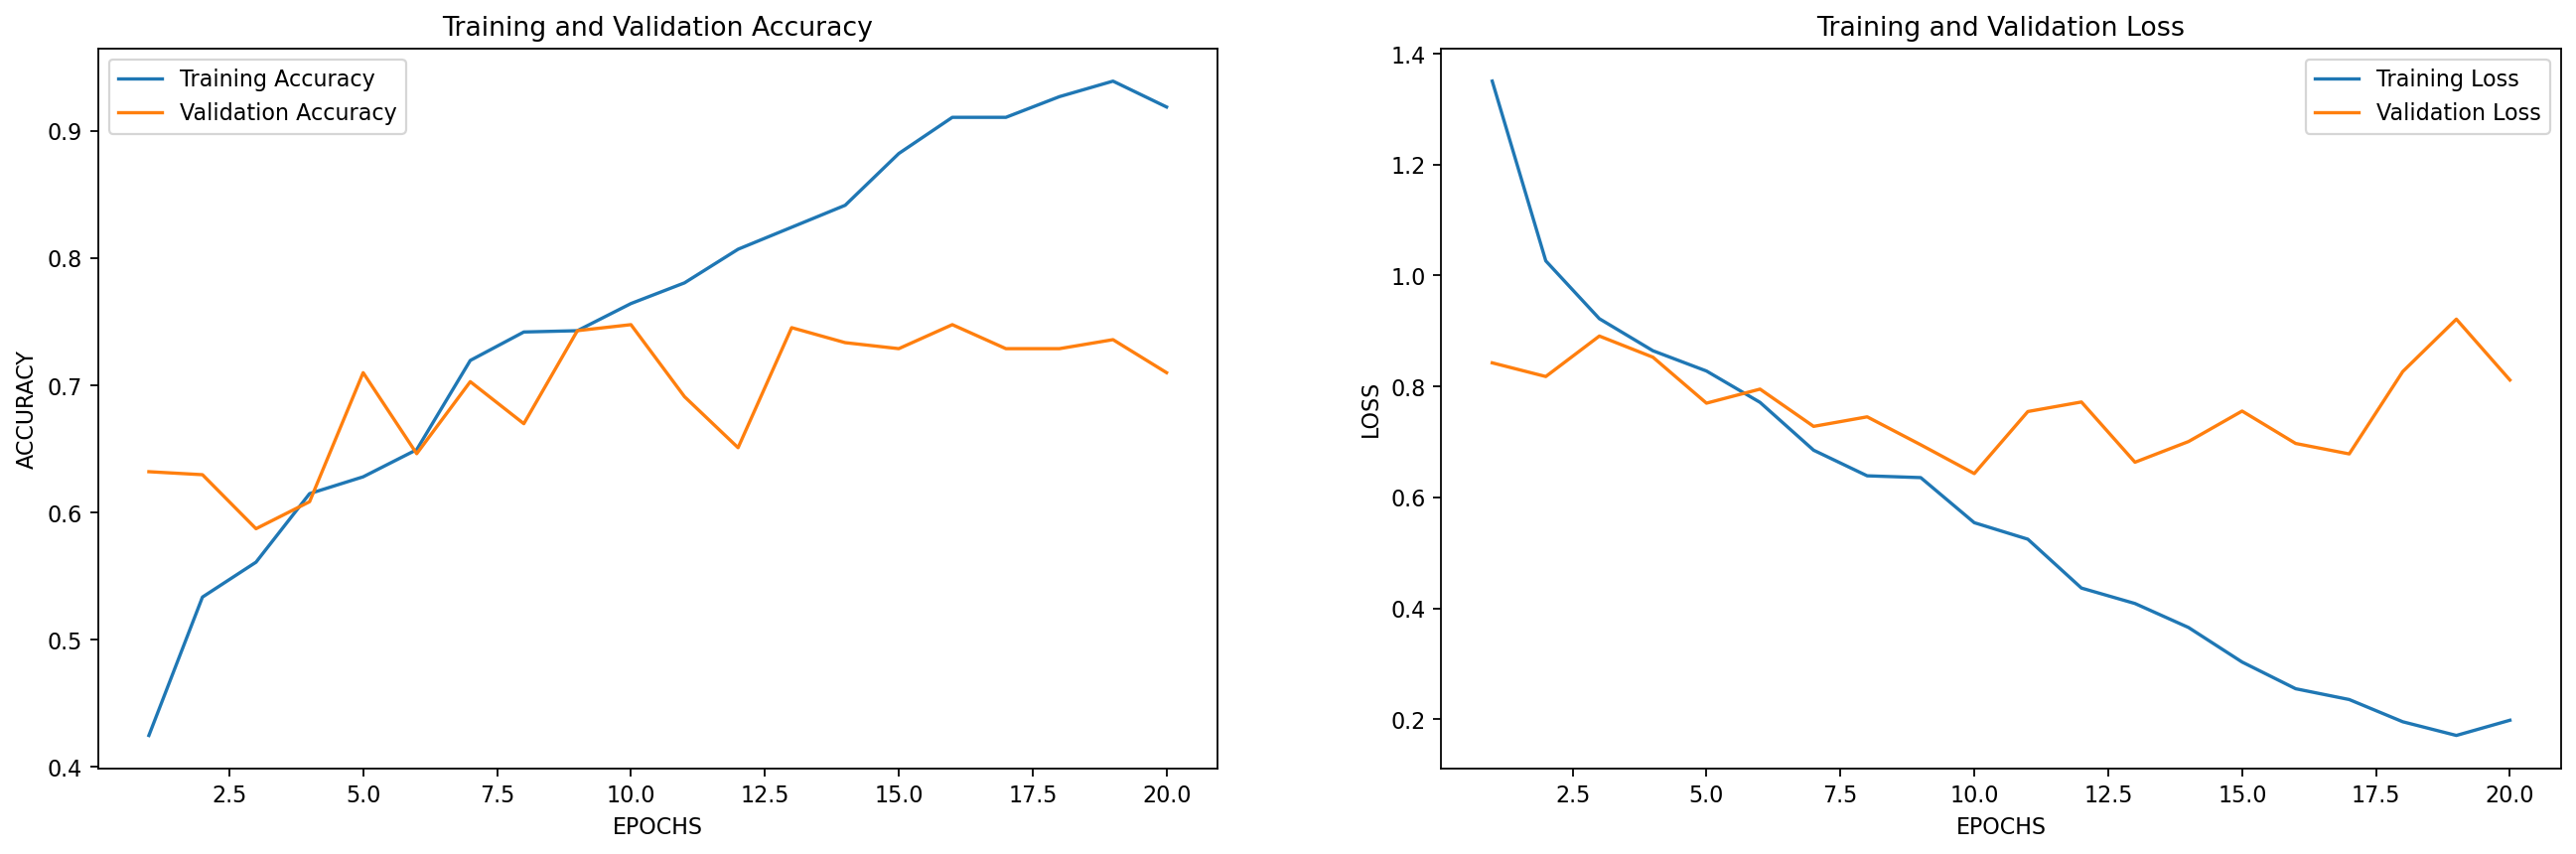

In [32]:
# Store history
utils.store_model_history(model_name, history.history)

# Plot training graphs
utils.plot_acc_loss(history.history)

20/20 [==============================] - 5s 265ms/step


 Evaluation Metrics:


Balanced Accuracy : 0.75
Precision : 0.77
Recall : 0.77
F1 Score: 0.77
ROC AUC Score : 0.9
Classification report : 
               precision    recall  f1-score   support

      Healthy       0.82      0.89      0.85        72
 Partial Tear       0.68      0.62      0.65        52
Complete Tear       0.78      0.76      0.77        33

     accuracy                           0.77       157
    macro avg       0.76      0.75      0.76       157
 weighted avg       0.77      0.77      0.77       157

Confusion Matrix : 


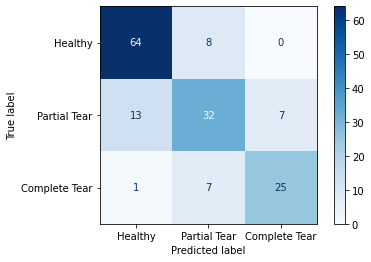

In [33]:
# Evaluate model
X_test_prob = kneeMRI_Model_TF_3_VGG.predict(utils.predict_batch_generator_tf_3(X_test, BATCH_SIZE))

X_test_pred = X_test_prob.argmax(axis=-1)

utils.evaluate_model(y_test, X_test_pred.tolist(), X_test_prob.tolist(), ['Healthy', 'Partial Tear', 'Complete Tear'])

## Mpdel 2 : Xception 256x256x3

In [26]:
model_name = 'kneeMRI_Model_TF_3_Xception'
kneeMRI_Model_TF_3_Xception = models.mri_model_tf_3_xception(model_name, len(kneemri_classes))
kneeMRI_Model_TF_3_Xception.compile(optimizer=keras.optimizers.Adam(learning_rate=utils.model_lr_schedule()),
                           loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])
kneeMRI_Model_TF_3_Xception.summary()

Model: "kneeMRI_Model_TF_3_Xception"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 512)               67109376  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128

In [27]:
%%time
with tf.device('/device:GPU:0'):
    history = kneeMRI_Model_TF_3_Xception.fit(utils.batch_generator_tf_3(X_train, y_train, BATCH_SIZE),
                                     steps_per_epoch=len(X_train)//BATCH_SIZE,
                                     epochs=EPOCHS,
                                     validation_data=utils.batch_generator_tf_3(X_valid, y_valid, BATCH_SIZE),
                                     validation_steps=len(X_valid)//BATCH_SIZE, 
                                     shuffle=True,
                                     class_weight=kneemri_class_weights,
                                     verbose=1,
                                     callbacks=[utils.model_callback_checkpoint(model_name), utils.model_callback_earlystopping()])

Epoch 1/100
123/123 [==============================] - 46s 302ms/step - loss: 1.7219 - accuracy: 0.3780 - val_loss: 1.0766 - val_accuracy: 0.4245
Epoch 2/100
123/123 [==============================] - 31s 252ms/step - loss: 1.1274 - accuracy: 0.4685 - val_loss: 0.9270 - val_accuracy: 0.5943
Epoch 3/100
123/123 [==============================] - 29s 234ms/step - loss: 1.0282 - accuracy: 0.5386 - val_loss: 0.9639 - val_accuracy: 0.5401
Epoch 4/100
123/123 [==============================] - 28s 232ms/step - loss: 0.9076 - accuracy: 0.5803 - val_loss: 0.9515 - val_accuracy: 0.5495
Epoch 5/100
123/123 [==============================] - 30s 244ms/step - loss: 0.8088 - accuracy: 0.6372 - val_loss: 0.8464 - val_accuracy: 0.6038
Epoch 6/100
123/123 [==============================] - 28s 230ms/step - loss: 0.7556 - accuracy: 0.6646 - val_loss: 0.8995 - val_accuracy: 0.5660
Epoch 7/100
123/123 [==============================] - 28s 226ms/step - loss: 0.6394 - accuracy: 0.7154 - val_loss: 0.8657 -

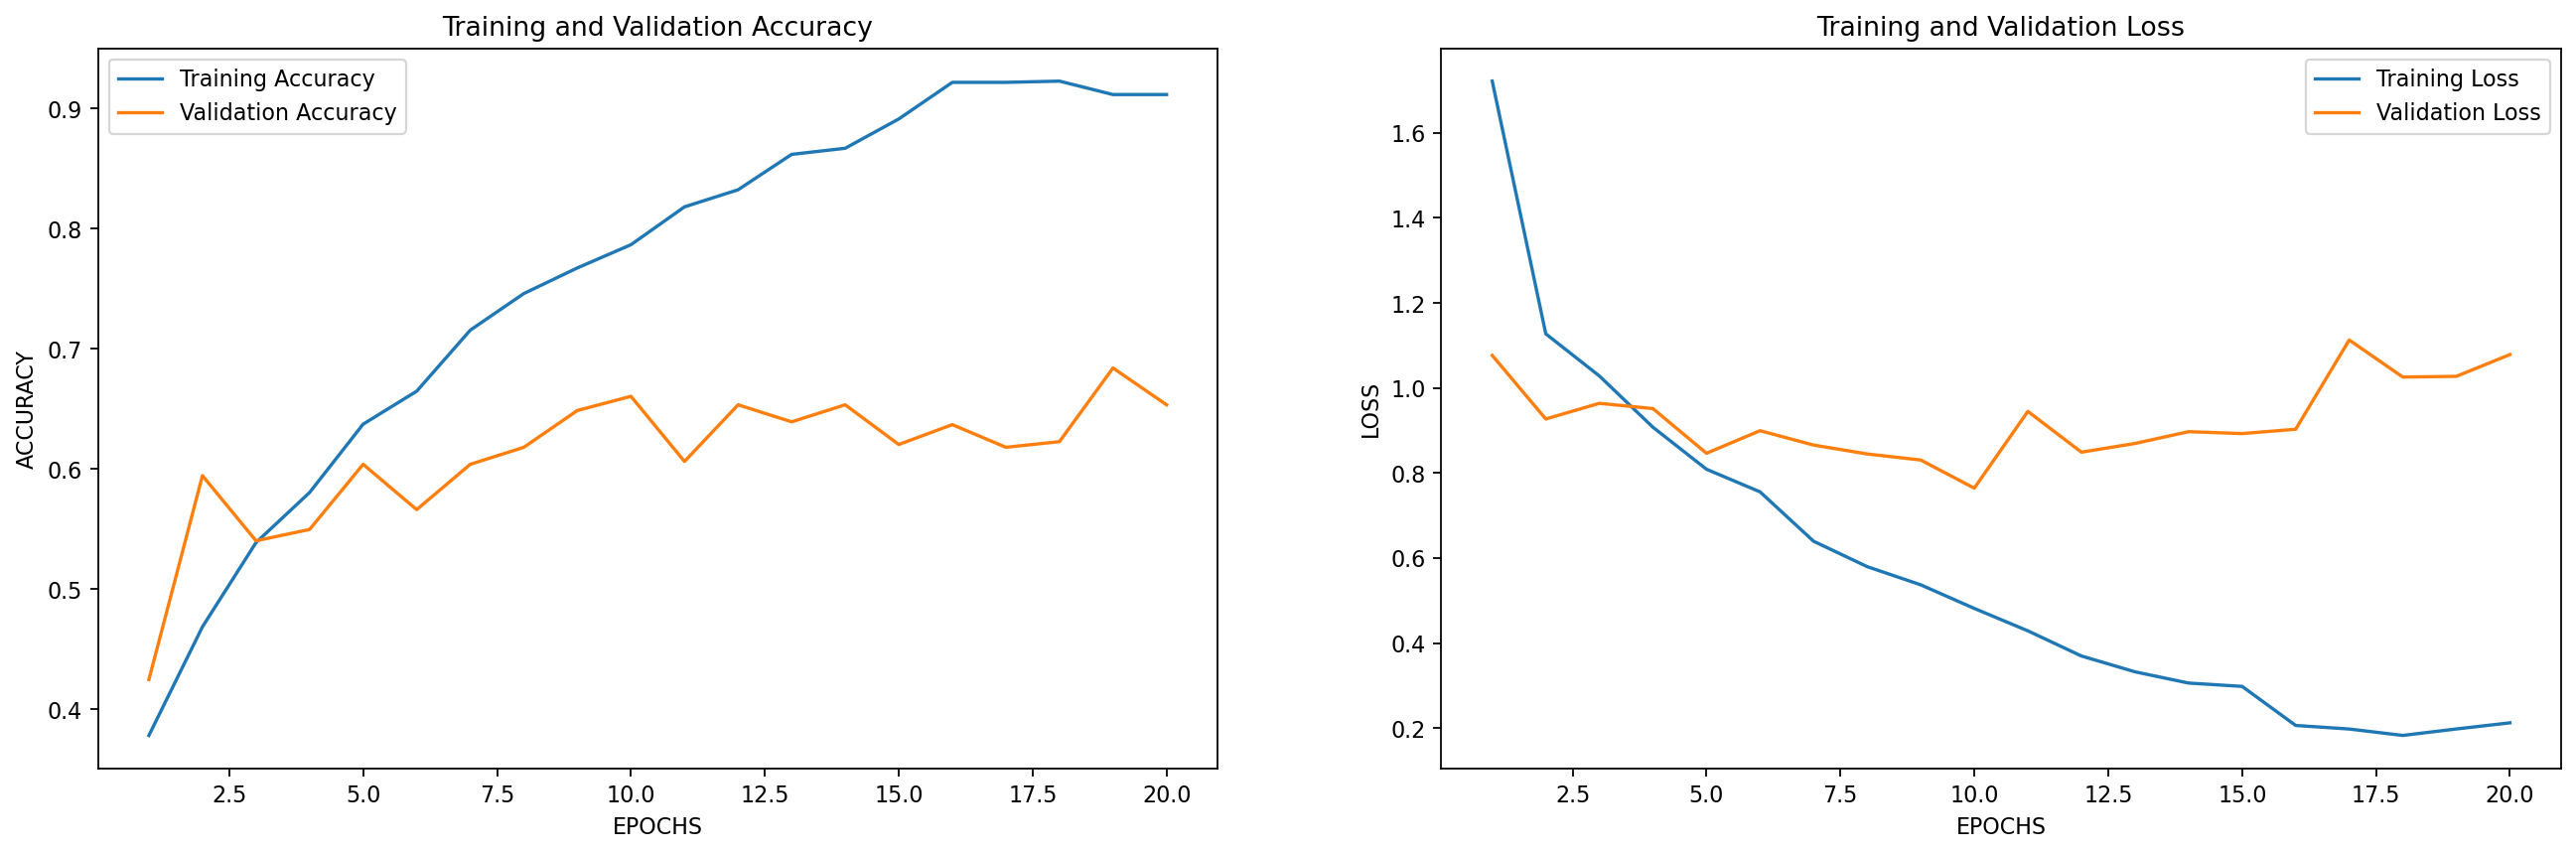

In [28]:
# Store history
utils.store_model_history(model_name, history.history)

# Plot training graphs
utils.plot_acc_loss(history.history)

20/20 [==============================] - 10s 507ms/step


 Evaluation Metrics:


Balanced Accuracy : 0.68
Precision : 0.7
Recall : 0.69
F1 Score: 0.7
ROC AUC Score : 0.84
Classification report : 
               precision    recall  f1-score   support

      Healthy       0.75      0.74      0.74        72
 Partial Tear       0.59      0.67      0.63        52
Complete Tear       0.78      0.64      0.70        33

     accuracy                           0.69       157
    macro avg       0.71      0.68      0.69       157
 weighted avg       0.70      0.69      0.70       157

Confusion Matrix : 


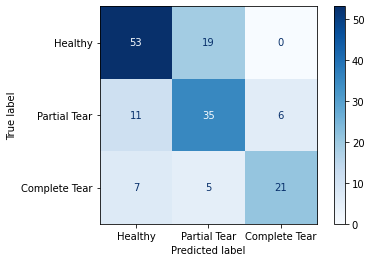

In [29]:
# Evaluate model
X_test_prob = kneeMRI_Model_TF_3_Xception.predict(utils.predict_batch_generator_tf_3(X_test, BATCH_SIZE))

X_test_pred = X_test_prob.argmax(axis=-1)

utils.evaluate_model(y_test, X_test_pred.tolist(), X_test_prob.tolist(), ['Healthy', 'Partial Tear', 'Complete Tear'])

## Model 3 : ResNet 256x256x3

In [26]:
model_name = 'kneeMRI_Model_TF_3_ResNet'
kneeMRI_Model_TF_3_ResNet = models.mri_model_tf_3_resnet(model_name, len(kneemri_classes))
kneeMRI_Model_TF_3_ResNet.compile(optimizer=keras.optimizers.Adam(learning_rate=utils.model_lr_schedule()),
                           loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])
kneeMRI_Model_TF_3_ResNet.summary()

Model: "kneeMRI_Model_TF_3_ResNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 512)               67109376  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128) 

In [27]:
%%time
with tf.device('/device:GPU:0'):
    history = kneeMRI_Model_TF_3_ResNet.fit(utils.batch_generator_tf_3(X_train, y_train, BATCH_SIZE),
                                     steps_per_epoch=len(X_train)//BATCH_SIZE,
                                     epochs=EPOCHS,
                                     validation_data=utils.batch_generator_tf_3(X_valid, y_valid, BATCH_SIZE),
                                     validation_steps=len(X_valid)//BATCH_SIZE, 
                                     shuffle=True,
                                     class_weight=kneemri_class_weights,
                                     verbose=1,
                                     callbacks=[utils.model_callback_checkpoint(model_name), utils.model_callback_earlystopping()])

Epoch 1/100
123/123 [==============================] - 48s 316ms/step - loss: 2.3201 - accuracy: 0.4096 - val_loss: 0.9742 - val_accuracy: 0.5259
Epoch 2/100
123/123 [==============================] - 32s 262ms/step - loss: 1.1856 - accuracy: 0.4299 - val_loss: 0.9893 - val_accuracy: 0.5613
Epoch 3/100
123/123 [==============================] - 32s 260ms/step - loss: 1.0316 - accuracy: 0.4959 - val_loss: 1.0162 - val_accuracy: 0.4929
Epoch 4/100
123/123 [==============================] - 32s 259ms/step - loss: 1.0550 - accuracy: 0.4980 - val_loss: 1.0149 - val_accuracy: 0.5236
Epoch 5/100
123/123 [==============================] - 34s 277ms/step - loss: 0.9189 - accuracy: 0.5376 - val_loss: 0.8644 - val_accuracy: 0.6486
Epoch 6/100
123/123 [==============================] - 34s 279ms/step - loss: 0.8897 - accuracy: 0.5650 - val_loss: 0.8201 - val_accuracy: 0.6533
Epoch 7/100
123/123 [==============================] - 32s 258ms/step - loss: 0.9046 - accuracy: 0.5264 - val_loss: 0.9058 -

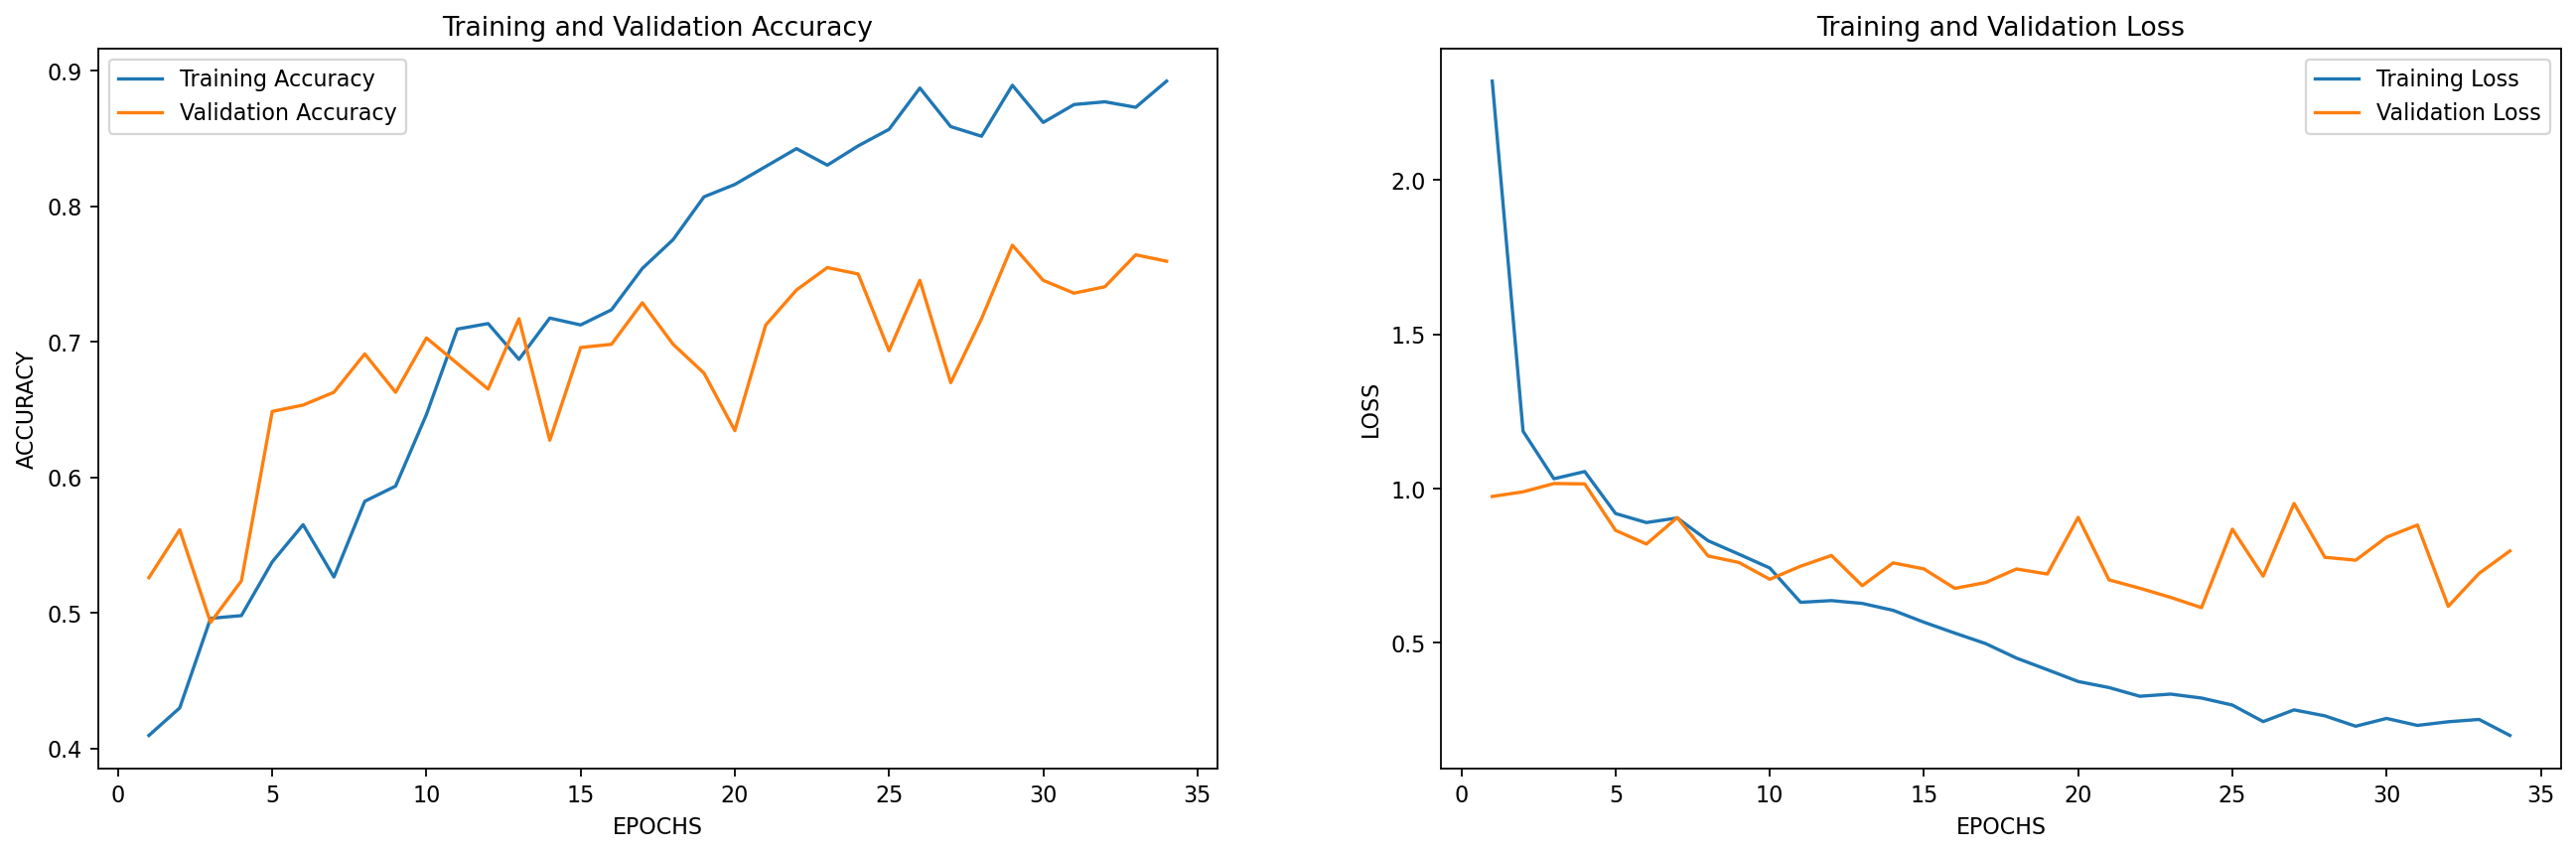

In [28]:
# Store history
utils.store_model_history(model_name, history.history)

# Plot training graphs
utils.plot_acc_loss(history.history)

20/20 [==============================] - 9s 456ms/step


 Evaluation Metrics:


Balanced Accuracy : 0.75
Precision : 0.76
Recall : 0.76
F1 Score: 0.76
ROC AUC Score : 0.9
Classification report : 
               precision    recall  f1-score   support

      Healthy       0.81      0.89      0.85        72
 Partial Tear       0.75      0.58      0.65        52
Complete Tear       0.68      0.79      0.73        33

     accuracy                           0.76       157
    macro avg       0.75      0.75      0.74       157
 weighted avg       0.76      0.76      0.76       157

Confusion Matrix : 


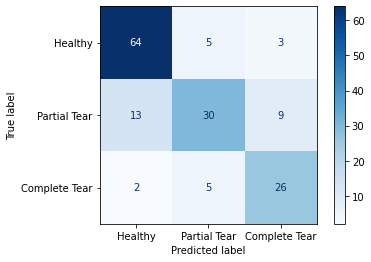

In [29]:
# Evaluate model
X_test_prob = kneeMRI_Model_TF_3_ResNet.predict(utils.predict_batch_generator_tf_3(X_test, BATCH_SIZE))

X_test_pred = X_test_prob.argmax(axis=-1)

utils.evaluate_model(y_test, X_test_pred.tolist(), X_test_prob.tolist(), ['Healthy', 'Partial Tear', 'Complete Tear'])

## Model 4 : VGG16 for 256x256x5

In [34]:
model_name = 'kneeMRI_Model_TF_5_VGG'
kneeMRI_Model_TF_5_VGG = models.mri_model_tf_5_vgg(model_name, len(kneemri_classes))
kneeMRI_Model_TF_5_VGG.compile(optimizer=keras.optimizers.Adam(learning_rate=utils.model_lr_schedule()),
                           loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])
kneeMRI_Model_TF_5_VGG.summary()

Model: "kneeMRI_Model_TF_5_VGG"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14715840  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_8 (Dense)             (None, 512)               16777728  
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 256)               131328    
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 128)    

In [35]:
%%time
with tf.device('/device:GPU:0'):
    history = kneeMRI_Model_TF_5_VGG.fit(utils.batch_generator_tf_5(X_train, y_train, BATCH_SIZE),
                                     steps_per_epoch=len(X_train)//BATCH_SIZE,
                                     epochs=EPOCHS,
                                     validation_data=utils.batch_generator_tf_5(X_valid, y_valid, BATCH_SIZE),
                                     validation_steps=len(X_valid)//BATCH_SIZE, 
                                     shuffle=True,
                                     class_weight=kneemri_class_weights,
                                     verbose=1,
                                     callbacks=[utils.model_callback_checkpoint(model_name), utils.model_callback_earlystopping()])

Epoch 1/100
123/123 [==============================] - 40s 319ms/step - loss: 1.2835 - accuracy: 0.4228 - val_loss: 0.9565 - val_accuracy: 0.4835
Epoch 2/100
123/123 [==============================] - 32s 257ms/step - loss: 1.0728 - accuracy: 0.4848 - val_loss: 0.8608 - val_accuracy: 0.5920
Epoch 3/100
123/123 [==============================] - 31s 255ms/step - loss: 0.9487 - accuracy: 0.5549 - val_loss: 0.8487 - val_accuracy: 0.6085
Epoch 4/100
123/123 [==============================] - 32s 260ms/step - loss: 0.8795 - accuracy: 0.5650 - val_loss: 0.8324 - val_accuracy: 0.6203
Epoch 5/100
123/123 [==============================] - 31s 251ms/step - loss: 0.7792 - accuracy: 0.6433 - val_loss: 0.7920 - val_accuracy: 0.6156
Epoch 6/100
123/123 [==============================] - 30s 248ms/step - loss: 0.7481 - accuracy: 0.6616 - val_loss: 0.7407 - val_accuracy: 0.6792
Epoch 7/100
123/123 [==============================] - 30s 249ms/step - loss: 0.7137 - accuracy: 0.6717 - val_loss: 0.7174 -

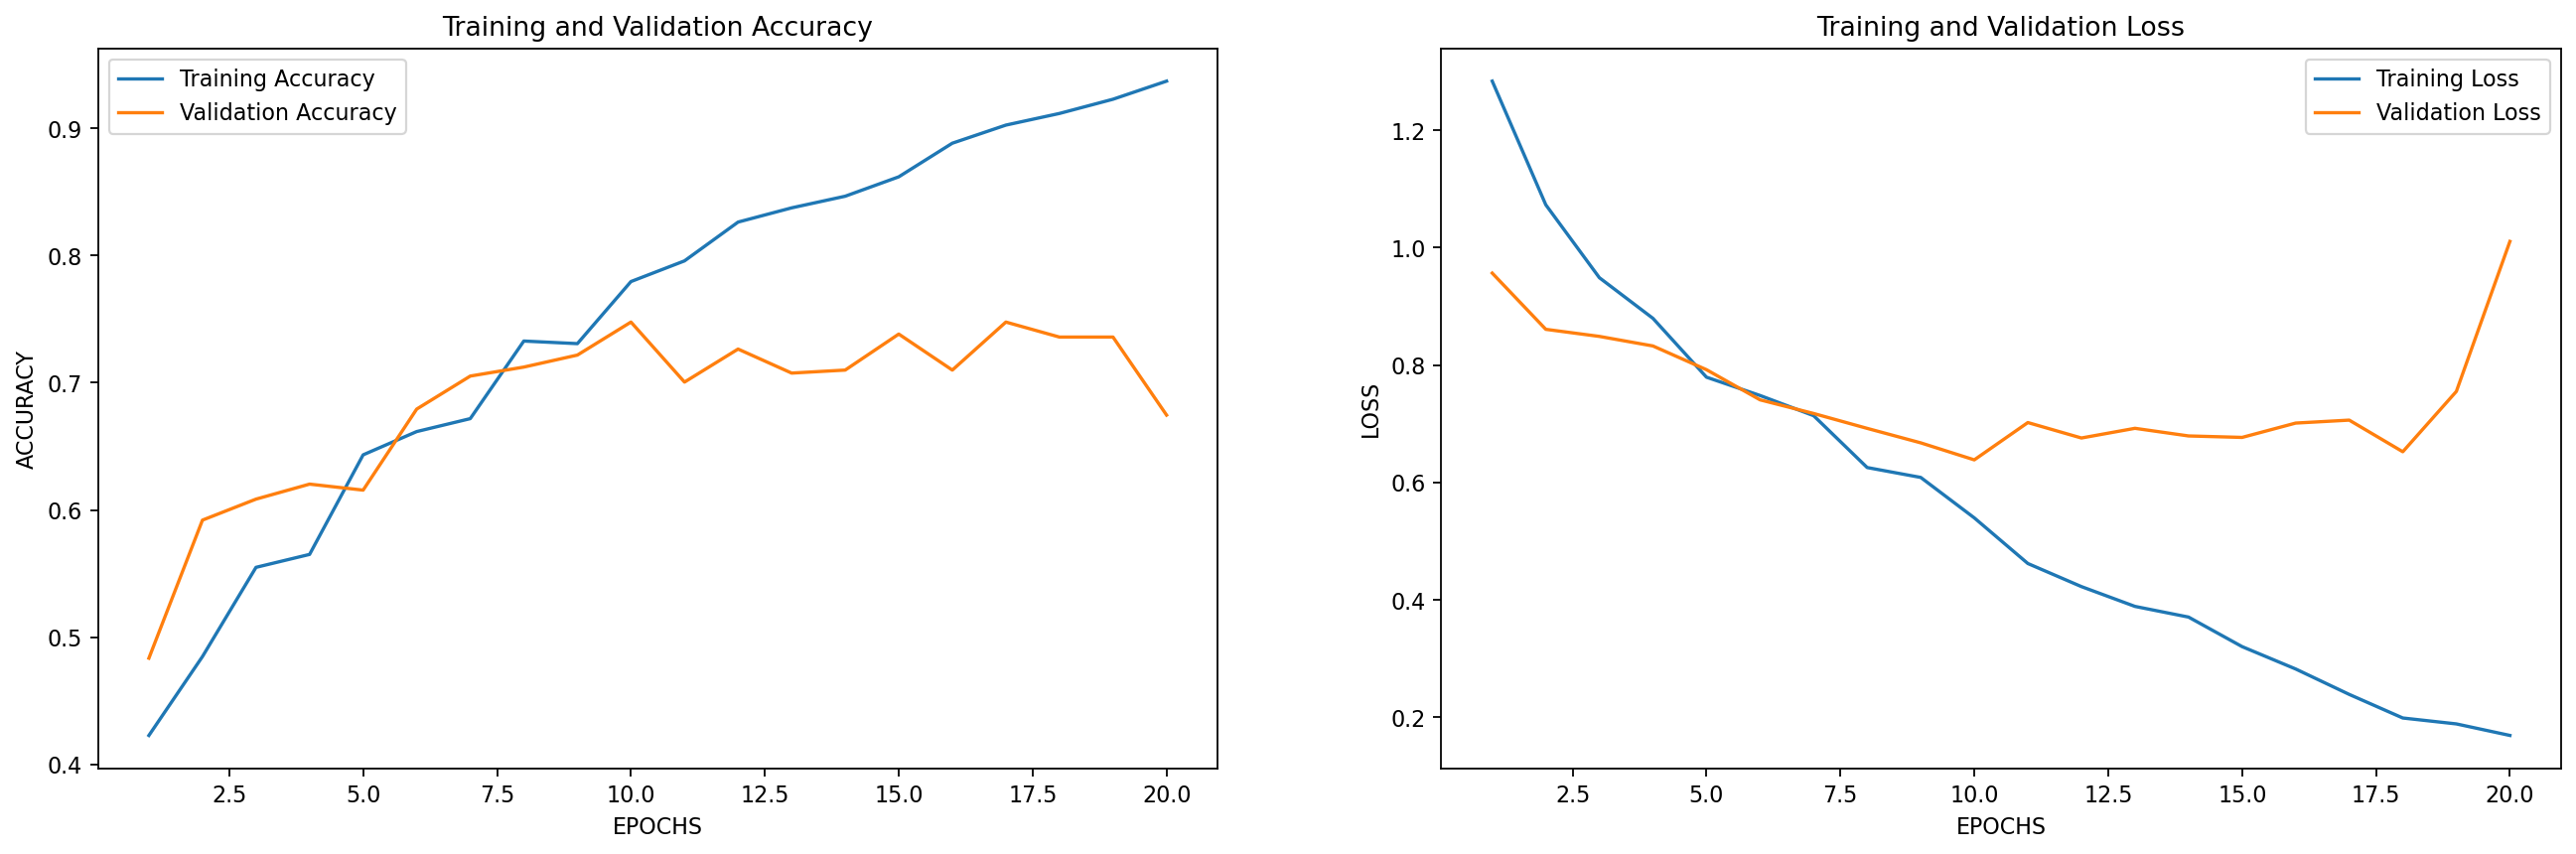

In [38]:
# Store history
utils.store_model_history(model_name, history.history)

# Plot training graphs
utils.plot_acc_loss(history.history)

20/20 [==============================] - 3s 143ms/step


 Evaluation Metrics:


Balanced Accuracy : 0.73
Precision : 0.76
Recall : 0.75
F1 Score: 0.75
ROC AUC Score : 0.91
Classification report : 
               precision    recall  f1-score   support

      Healthy       0.77      0.88      0.82        72
 Partial Tear       0.66      0.63      0.65        52
Complete Tear       0.88      0.67      0.76        33

     accuracy                           0.75       157
    macro avg       0.77      0.73      0.74       157
 weighted avg       0.76      0.75      0.75       157

Confusion Matrix : 


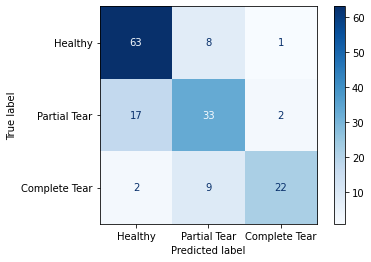

In [39]:
# Evaluate model
X_test_prob = kneeMRI_Model_TF_5_VGG.predict(utils.predict_batch_generator_tf_5(X_test, BATCH_SIZE))

X_test_pred = X_test_prob.argmax(axis=-1)

utils.evaluate_model(y_test, X_test_pred.tolist(), X_test_prob.tolist(), ['Healthy', 'Partial Tear', 'Complete Tear'])

## Model 5 : ResNet 256x256x5

In [31]:
model_name = 'kneeMRI_Model_TF_5_ResNet'
kneeMRI_Model_TF_5_ResNet = models.mri_model_tf_5_resnet(model_name, len(kneemri_classes))
kneeMRI_Model_TF_5_ResNet.compile(optimizer=keras.optimizers.Adam(learning_rate=utils.model_lr_schedule()),
                           loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])
kneeMRI_Model_TF_5_ResNet.summary()

Model: "kneeMRI_Model_TF_5_ResNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23593984  
                                                                 
 flatten_1 (Flatten)         (None, 131072)            0         
                                                                 
 dense_4 (Dense)             (None, 512)               67109376  
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128) 

In [32]:
%%time
with tf.device('/device:GPU:0'):
    history = kneeMRI_Model_TF_5_ResNet.fit(utils.batch_generator_tf_5(X_train, y_train, BATCH_SIZE),
                                     steps_per_epoch=len(X_train)//BATCH_SIZE,
                                     epochs=EPOCHS,
                                     validation_data=utils.batch_generator_tf_5(X_valid, y_valid, BATCH_SIZE),
                                     validation_steps=len(X_valid)//BATCH_SIZE, 
                                     shuffle=True,
                                     class_weight=kneemri_class_weights,
                                     verbose=1,
                                     callbacks=[utils.model_callback_checkpoint(model_name), utils.model_callback_earlystopping()])

Epoch 1/100
123/123 [==============================] - 42s 326ms/step - loss: 2.6507 - accuracy: 0.3618 - val_loss: 1.2343 - val_accuracy: 0.3608
Epoch 2/100
123/123 [==============================] - 31s 256ms/step - loss: 1.4225 - accuracy: 0.4522 - val_loss: 0.9574 - val_accuracy: 0.5755
Epoch 3/100
123/123 [==============================] - 29s 240ms/step - loss: 1.0795 - accuracy: 0.4837 - val_loss: 1.0093 - val_accuracy: 0.5330
Epoch 4/100
123/123 [==============================] - 29s 234ms/step - loss: 1.0076 - accuracy: 0.5041 - val_loss: 0.9891 - val_accuracy: 0.5778
Epoch 5/100
123/123 [==============================] - 30s 242ms/step - loss: 0.9375 - accuracy: 0.5295 - val_loss: 0.9359 - val_accuracy: 0.6061
Epoch 6/100
123/123 [==============================] - 28s 230ms/step - loss: 0.9000 - accuracy: 0.5518 - val_loss: 0.9368 - val_accuracy: 0.5920
Epoch 7/100
123/123 [==============================] - 28s 227ms/step - loss: 0.8617 - accuracy: 0.5793 - val_loss: 0.9401 -

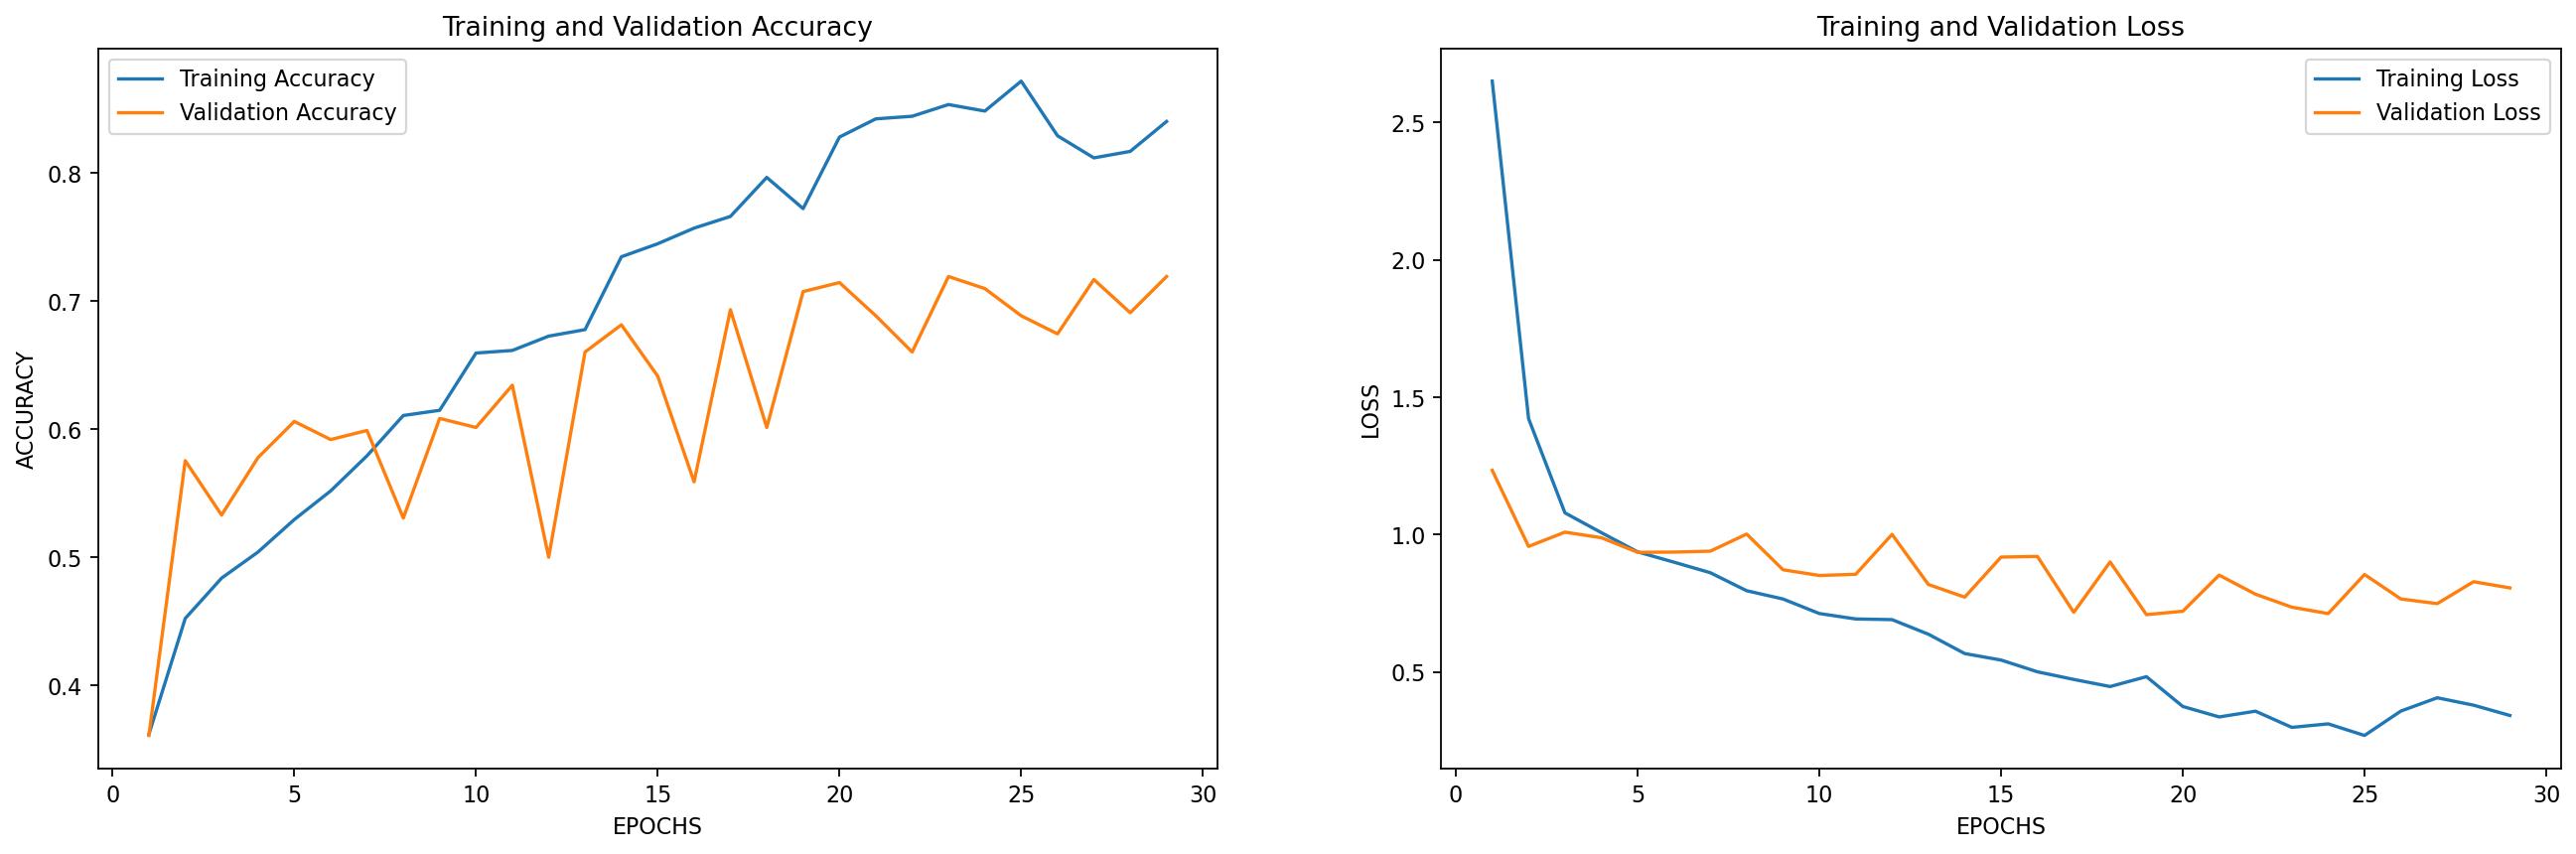

In [33]:
# Store history
utils.store_model_history(model_name, history.history)

# Plot training graphs
utils.plot_acc_loss(history.history)

20/20 [==============================] - 5s 208ms/step


 Evaluation Metrics:


Balanced Accuracy : 0.76
Precision : 0.78
Recall : 0.78
F1 Score: 0.77
ROC AUC Score : 0.89
Classification report : 
               precision    recall  f1-score   support

      Healthy       0.76      0.92      0.83        72
 Partial Tear       0.82      0.60      0.69        52
Complete Tear       0.78      0.76      0.77        33

     accuracy                           0.78       157
    macro avg       0.79      0.76      0.76       157
 weighted avg       0.78      0.78      0.77       157

Confusion Matrix : 


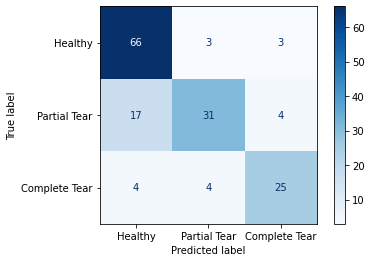

In [34]:
# Evaluate model
X_test_prob = kneeMRI_Model_TF_5_ResNet.predict(utils.predict_batch_generator_tf_5(X_test, BATCH_SIZE))

X_test_pred = X_test_prob.argmax(axis=-1)

utils.evaluate_model(y_test, X_test_pred.tolist(), X_test_prob.tolist(), ['Healthy', 'Partial Tear', 'Complete Tear'])